# Data collation

## English models

In [123]:
import pandas as pd
import gensim.downloader

FASTTEXT = "fasttext-wiki-news-subwords-300"
WORD2VEC = "word2vec-google-news-300"
GLOVE = "glove-wiki-gigaword-300"
ENGLISH_MODELS = [FASTTEXT, WORD2VEC, GLOVE]

if False:
    # English vectors over different models
    for modelname in MODELS:
        print(f"Saving {modelname}")
        model = gensim.downloader.load(modelname)
        model.save(f"data/raw/{modelname}.model")

    english_counts = pd.read_csv("data/raw/english_counts.csv")

    for modelname in ENGLISH_MODELS:
        print(f"Opening {modelname}")
        model = gensim.models.KeyedVectors.load(f"data/raw/{modelname}.model")
        words = model.index_to_key
        vectors = model.vectors
        magnitudes = (vectors**2).sum(axis=1) ** 0.5

        df = pd.DataFrame({"word": words, "magnitude": magnitudes})
        df = df.merge(english_counts, on="word")

        df["frequency"] = df["count"] / df["count"].sum()
        df["frequency_rank"] = df["frequency"].rank(ascending=False).astype(int)
        df["magnitude_rank"] = df["magnitude"].rank(ascending=False).astype(int)

        df.to_csv(f"data/clean/{modelname}.csv", index=False)

## Spanish word counts

In [124]:
from sklearn.feature_extraction.text import CountVectorizer
import os
import chardet
import pandas as pd
from multiprocessing import Pool
from tqdm import tqdm

if False:

    def process_file(file):
        with open(file, "rb") as f:
            raw_data = f.read()
            result = chardet.detect(raw_data)
            encoding = result["encoding"]

            try:
                content = raw_data.decode(encoding)
            except UnicodeDecodeError:
                content = raw_data.decode(encoding, errors="replace")

        vectorizer = CountVectorizer()
        spanish_counts = vectorizer.fit_transform([content])
        spanish_words = vectorizer.get_feature_names_out()
        word_counts = spanish_counts.toarray()[0]

        return {word: count for word, count in zip(spanish_words, word_counts)}

    directory = "data/raw/spanish_corpus"
    files = [os.path.join(directory, file) for file in os.listdir(directory)]

    with Pool() as pool:
        with tqdm(total=len(files), desc="Processing files") as pbar:
            word_counts_list = []
            for result in pool.imap_unordered(process_file, files):
                word_counts_list.append(result)
                pbar.update(1)

    # Combine word counts from all files
    combined_word_counts = {}
    for word_counts in word_counts_list:
        for word, count in word_counts.items():
            combined_word_counts[word] = combined_word_counts.get(word, 0) + count

    word_counts_df = pd.DataFrame(
        combined_word_counts.items(), columns=["word", "count"]
    )
    word_counts_df.to_csv("data/raw/spanish_counts.csv", index=False)

# Experiments

## Confirm Zipf's Law

Best fit parameter - c: 0.04842680629829203


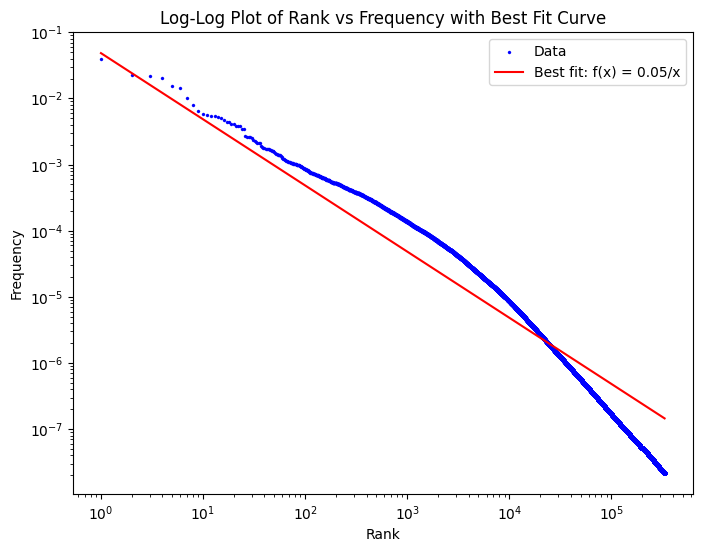

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit


# Define the new power law function with only parameter c
def power_law(x, c):
    return c / x


# Load the data
df_english_counts = pd.read_csv("data/raw/english_counts.csv")
df_english_counts["rank"] = df_english_counts["count"].rank(ascending=False).astype(int)
df_english_counts["frequency"] = (
    df_english_counts["count"] / df_english_counts["count"].sum()
)

# Extract x and y data
x_data = df_english_counts["rank"].values
y_data = df_english_counts["frequency"].values

# Fit the curve with the new function
params, covariance = curve_fit(power_law, x_data, y_data)
c_best_fit = params[0]
print(f"Best fit parameter - c: {c_best_fit}")

# Plot the data and the best fit curve
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_english_counts,
    x="rank",
    y="frequency",
    color="blue",
    edgecolor=None,
    label="Data",
    s=5,
)
plt.plot(
    x_data,
    power_law(x_data, c_best_fit),
    color="red",
    label=f"Best fit: f(x) = {c_best_fit:.2f}/x",
)
plt.ylabel("Frequency")
plt.xlabel("Rank")
plt.xscale("log")
plt.yscale("log")
plt.title("Log-Log Plot of Rank vs Frequency with Best Fit Curve")
plt.legend()
plt.show()

## Calculate correlations

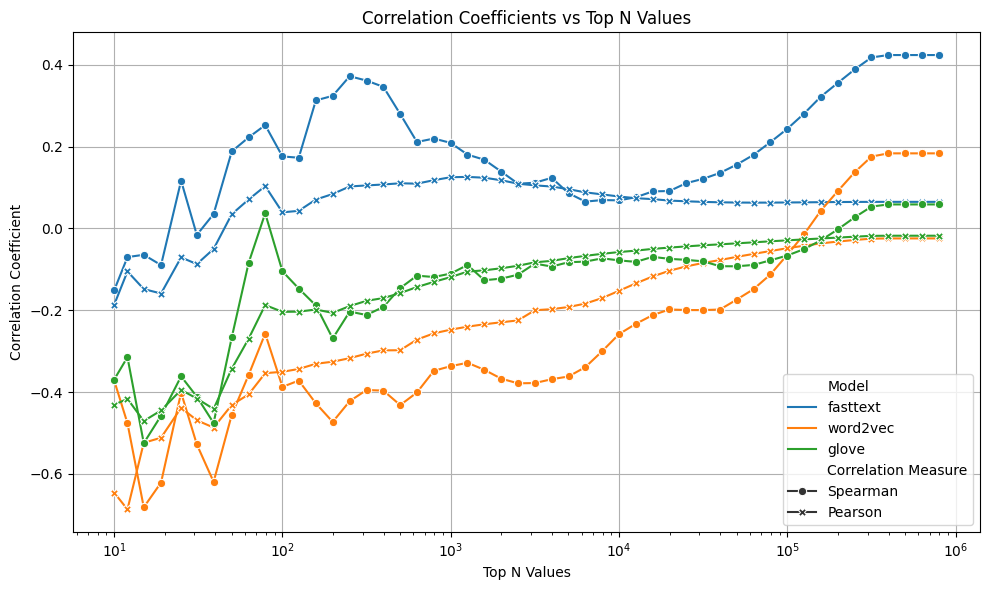

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

# Load dataframes
models = [
    "fasttext-wiki-news-subwords-300",
    "word2vec-google-news-300",
    "glove-wiki-gigaword-300",
]

start_value = 10
ratio = 10 ** (1 / 10)
num_values = 50

top_n_values = [int(start_value * (ratio**i)) for i in range(num_values)]

# Calculate correlations
corrs = []
for top_n in top_n_values:
    df_english_counts = pd.read_csv("data/raw/english_counts.csv")
    df_english_counts = df_english_counts.sort_values("count", ascending=False).head(
        top_n
    )

    for model in models:
        df_model = pd.read_csv(f"data/clean/{model}.csv").merge(
            df_english_counts, on="word"
        )
        spearman_corr, _ = spearmanr(
            df_model["magnitude_rank"], df_model["frequency_rank"]
        )
        pearson_corr, _ = pearsonr(df_model["magnitude"], df_model["frequency"])
        corrs.append(
            {
                "Top N Values": top_n,
                "Correlation Coefficient": spearman_corr,
                "Correlation Measure": "Spearman",
                "Model": model.split("-")[0],
            }
        )
        corrs.append(
            {
                "Top N Values": top_n,
                "Correlation Coefficient": pearson_corr,
                "Correlation Measure": "Pearson",
                "Model": model.split("-")[0],
            }
        )

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=pd.DataFrame(corrs),
    x="Top N Values",
    y="Correlation Coefficient",
    hue="Model",
    style="Correlation Measure",
    markers=True,
    dashes=False,
)
plt.xscale("log")
plt.xlabel("Top N Values")
plt.ylabel("Correlation Coefficient")
plt.title("Correlation Coefficients vs Top N Values")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()